# ART.T551 Image and Video Recognition Final Report

## 20M31378 Xu Hongkun

## Convolutional Network

In [1]:
import torch
from torch import optim
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms


import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps

from invert import Invert
import random

In [2]:
# star, note, heart, diamond, cross 
Dataset = ["U26E4", "U266B", "U2661", "U2662", "U2715"]

Training_Path = "./TrainDataset"
Testing_Path = "./TestDataset"

BATCH_SIZE = 25
IMG_SIZE= 256

## 1.Dataset

In [3]:
from torchvision.datasets import ImageFolder

transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                transforms.Grayscale(num_output_channels=1), # 灰度化
                                Invert(),
                                # transforms.RandomHorizontalFlip(), # 随机水平翻转
                                transforms.ToTensor(),
                                ])

# 1. 卷积网络训练集(training dataset)
training_dataset = ImageFolder(Training_Path, transform=transform)
train_class = training_dataset.class_to_idx
print("train dataset labels:", train_class) # 检查训练数据集对应文件夹的label

train_loader = torch.utils.data.DataLoader(training_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True,
                                           )

# 2. 卷积网络测试集(testing dataset)
testing_dataset = ImageFolder(Testing_Path, transform=transform)
test_class = testing_dataset.class_to_idx
print("test dataset labels:", test_class) # 检查测试数据集对应文件夹的label

test_loader = torch.utils.data.DataLoader(testing_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True,
                                           )

train dataset labels: {'U2661': 0, 'U2662': 1, 'U266B': 2, 'U26E4': 3, 'U2715': 4}
test dataset labels: {'U2661': 0, 'U2662': 1, 'U266B': 2, 'U26E4': 3, 'U2715': 4}


### Training Samples

In [4]:
batch = next(iter(train_loader))
images, labels = batch
print(images.shape,'\t',labels.shape)

torch.Size([25, 1, 256, 256]) 	 torch.Size([25])


labels: tensor([[1, 0, 4, 3, 3],
        [0, 4, 4, 3, 1],
        [4, 2, 0, 0, 4],
        [4, 3, 2, 3, 2],
        [3, 2, 0, 3, 2]])


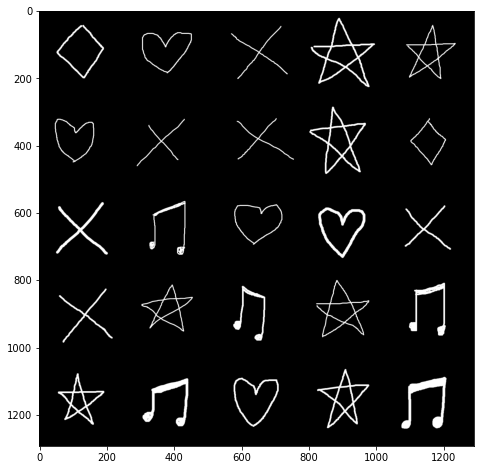

In [5]:
SHOW_NUMBER = 5 # 有几行几列

grid = torchvision.utils.make_grid(images, nrow=SHOW_NUMBER) # nrow：Number of images per row

plt.figure(figsize=(8,8)) # figure size
plt.imshow(np.transpose(grid, (1,2,0)))

# esp_fig = plt.gcf() # get current figure
# esp_fig.savefig('./images/Training.png', format='png', bbox_inches='tight')

print('labels:', labels.reshape(SHOW_NUMBER,SHOW_NUMBER))
plt.show()

### Testing Samples

0


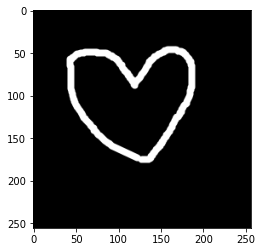

In [6]:
plt.imshow(testing_dataset[0][0][0], cmap='gray')
print(testing_dataset[0][1])
plt.show()

## 2. Model

In [7]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            # 1, 256, 256
            nn.Conv2d(1, 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.MaxPool2d(2, stride=2),
            
            # 4, 128, 128
            nn.Conv2d(4, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, stride=2),
            
            # 8, 64, 64
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, stride=2)
            
            # 8, 32, 32
        )

        self.fc1 = nn.Sequential(
            # 8, 32, 32
            nn.Linear(8*32*32, 1000),
            nn.ReLU(inplace=True),
            
            # 1000
            nn.Linear(1000, 100),
            nn.ReLU(inplace=True),
            
            # 100
            nn.Linear(100, 5)
            
            # 5
        )
        
        
    def forward(self, inputvec):
        outputvec = self.cnn1(inputvec)
        outputvec = outputvec.view(outputvec.size()[0], -1)
        outputvec = self.fc1(outputvec)

        return outputvec
    

## 3.Training

In [8]:
def get_num_correct(preds, labels):
    '''
    Calculate the number of correct predictions
    '''
    return preds.argmax(dim=1).eq(labels).sum().item()

In [13]:
# Hyperparameters
NUMBER_EPOCHS= 30

net = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss() # Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

counter = []
Training_loss_history = [] 
Testing_loss_history = []
iteration_number = 0
Correct_number = 0

# Training times
for epoch in range(0, NUMBER_EPOCHS):
    train_loss = 0
    train_correct = 0
    
    for i, batch in enumerate(train_loader, 0):
        images, labels = batch

        optimizer.zero_grad() # clear the calculated grad in previous batch
        output = net(images)
        training_loss = criterion(output, labels)
        training_loss.backward()
        optimizer.step()

        if i % 10 == 0: # show changes of loss value after each 10 batches
            with torch.no_grad():
                Correct_number = 0
                for items in test_loader:
                    test_imgs, test_labels = items
                    test_output = net(test_imgs)
                    Correct_number += get_num_correct(test_output, test_labels)

                test_accuracy = 100 * Correct_number/(len(test_loader)*BATCH_SIZE)
            
            print(f"Epoch: {epoch}, Training loss: {training_loss.item()}, Test accuracy: {test_accuracy:.2f}%")
            iteration_number += 10
            counter.append(iteration_number)
            Training_loss_history.append(training_loss.item())
            Testing_loss_history.append(test_accuracy)   


# save model
torch.save(net, './model/Model2.pkl')

Epoch: 0, Training loss: 1.614952802658081, Test accuracy: 16.00%
Epoch: 1, Training loss: 1.6063804626464844, Test accuracy: 24.00%
Epoch: 2, Training loss: 1.4846426248550415, Test accuracy: 40.00%
Epoch: 3, Training loss: 1.3534605503082275, Test accuracy: 64.00%
Epoch: 4, Training loss: 1.2493518590927124, Test accuracy: 76.00%
Epoch: 5, Training loss: 1.1189618110656738, Test accuracy: 80.00%
Epoch: 6, Training loss: 0.9516149163246155, Test accuracy: 88.00%
Epoch: 7, Training loss: 0.8434784412384033, Test accuracy: 92.00%
Epoch: 8, Training loss: 0.7611784338951111, Test accuracy: 96.00%
Epoch: 9, Training loss: 0.6201112270355225, Test accuracy: 96.00%
Epoch: 10, Training loss: 0.5023008584976196, Test accuracy: 96.00%
Epoch: 11, Training loss: 0.4282112419605255, Test accuracy: 96.00%
Epoch: 12, Training loss: 0.31506359577178955, Test accuracy: 96.00%
Epoch: 13, Training loss: 0.281838983297348, Test accuracy: 96.00%
Epoch: 14, Training loss: 0.20668953657150269, Test accurac

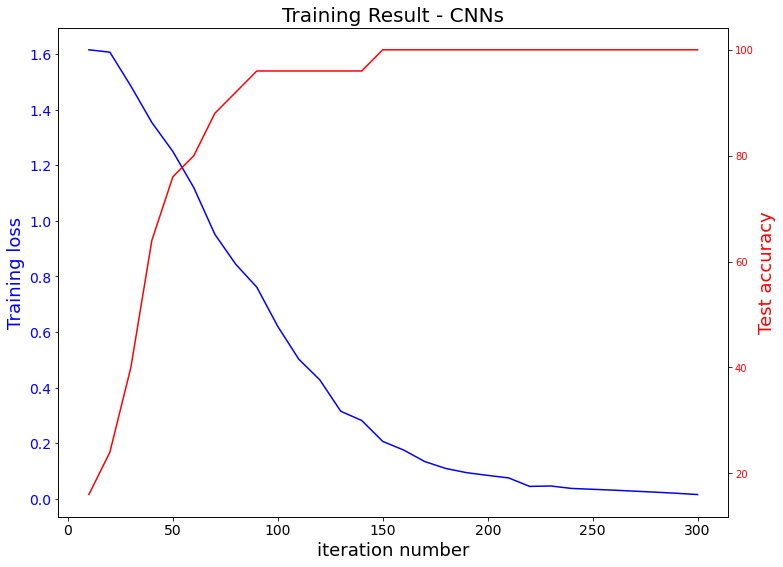

In [14]:
fig, ax1 = plt.subplots(figsize=(12,9))
plt.title("Training Result - CNNs", fontsize=20)
plt.xlabel('iteration number', fontsize=18)

# plt.grid(axis='y',color='grey',linestyle='--',lw=0.5,alpha=0.5)
plt.tick_params(axis='both',labelsize=14)
plot1 = ax1.plot(counter, Training_loss_history, 'b', label='Training loss')
ax1.set_ylabel('Training loss', fontsize = 18)
ax1.yaxis.label.set_color('blue')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
plot2 = ax2.plot(counter, Testing_loss_history, 'r', label='Test accuracy')
# ax2.set_ylim(0,1.1)
ax2.yaxis.label.set_color('red')
ax2.set_ylabel('Test accuracy',fontsize=18)
for tl in ax2.get_yticklabels():
    tl.set_color('r')

# ax1.set_yticks(np.linspace(ax1.get_ybound()[0],ax1.get_ybound()[1],9)) 
# ax2.set_yticks(np.linspace(ax2.get_ybound()[0],ax2.get_ybound()[1],9)) 

esp_fig = plt.gcf() # get current figure
esp_fig.savefig('./images/CNN_Training_Result.png', format='png', bbox_inches='tight')

plt.show()